In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import product
from scipy.ndimage import gaussian_filter
from itertools import product
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os
from fpdf import FPDF
import joblib
from datetime import datetime
import helper_functions as hf
from constants import(
    platoon_state_mapping,
    side_buckets,
    height_buckets,
    count_values,
    num_clusters,
    numerical_features,
    pseudo_sample_size,
    median_features,
    columns_to_keep
)
import warnings
warnings.filterwarnings('ignore')

rv_model = joblib.load('rv_model.pkl')
gmm_models = hf.load_gmm_models()
scaler = joblib.load("scaler.pkl")

pitches_df = pd.read_csv('all_pitches.csv')
global_means = pd.read_csv('global_means.csv')

pitches_df = hf.prepare_data(pitches_df, game_only=False)

scaled_columns = [f"{feature}_Scaled" for feature in numerical_features]
pitches_df[scaled_columns] = scaler.transform(pitches_df[numerical_features])

PDF saved as pdfs/farley_georgia_20250129.pdf


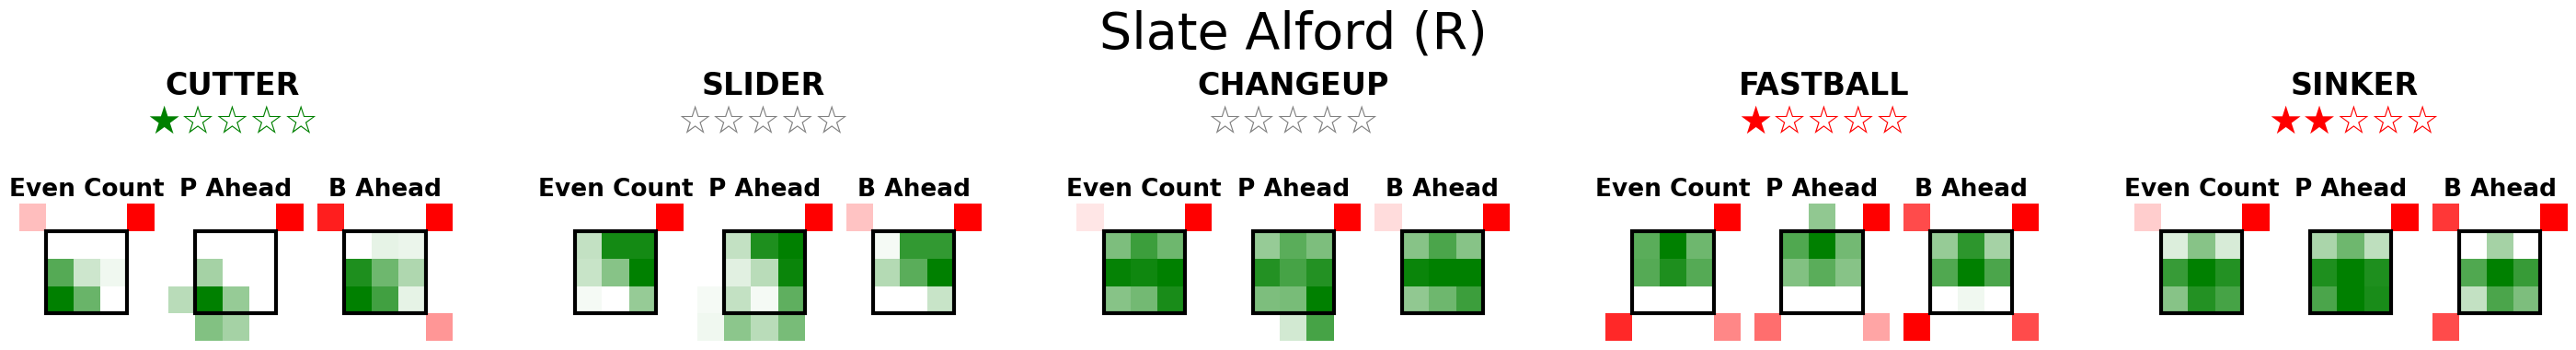

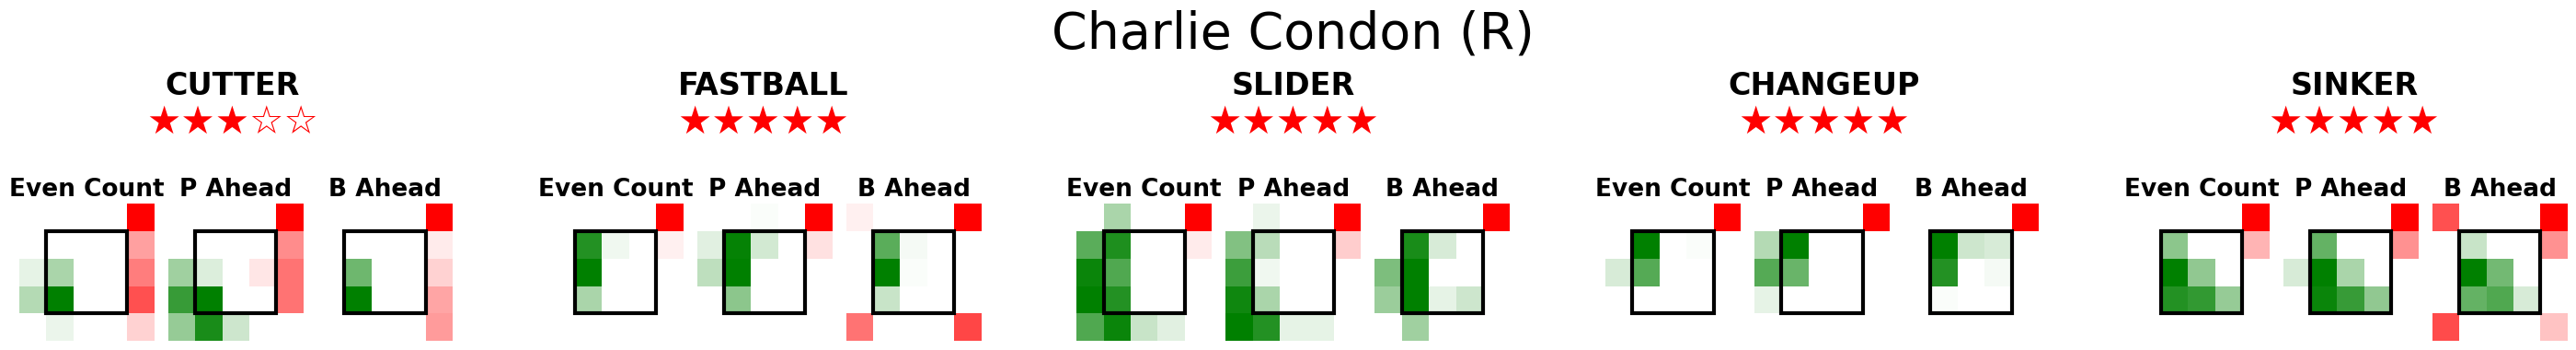

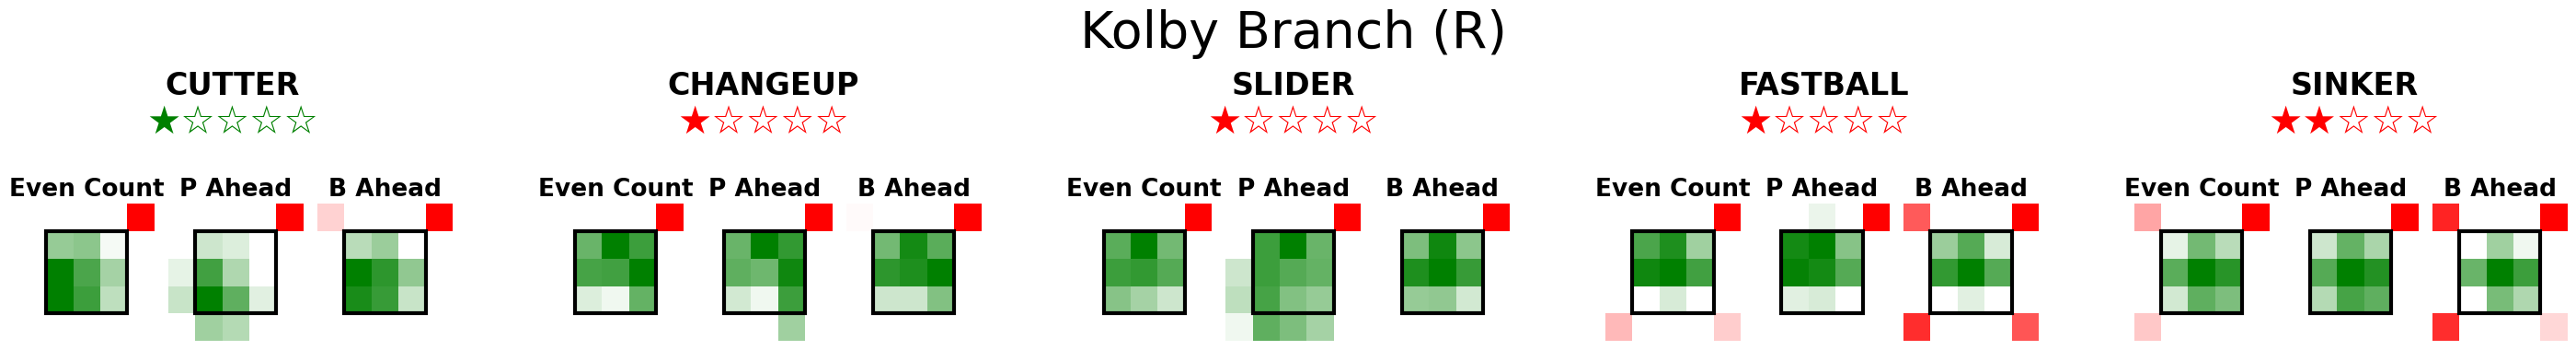

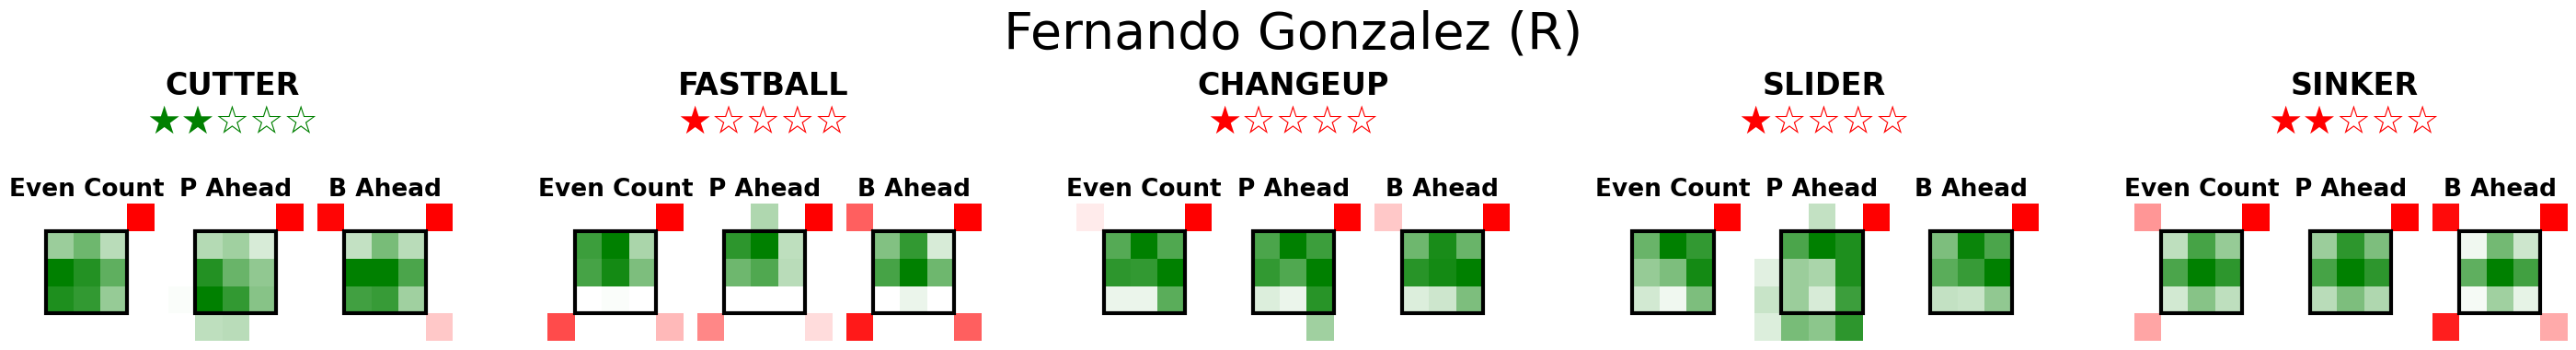

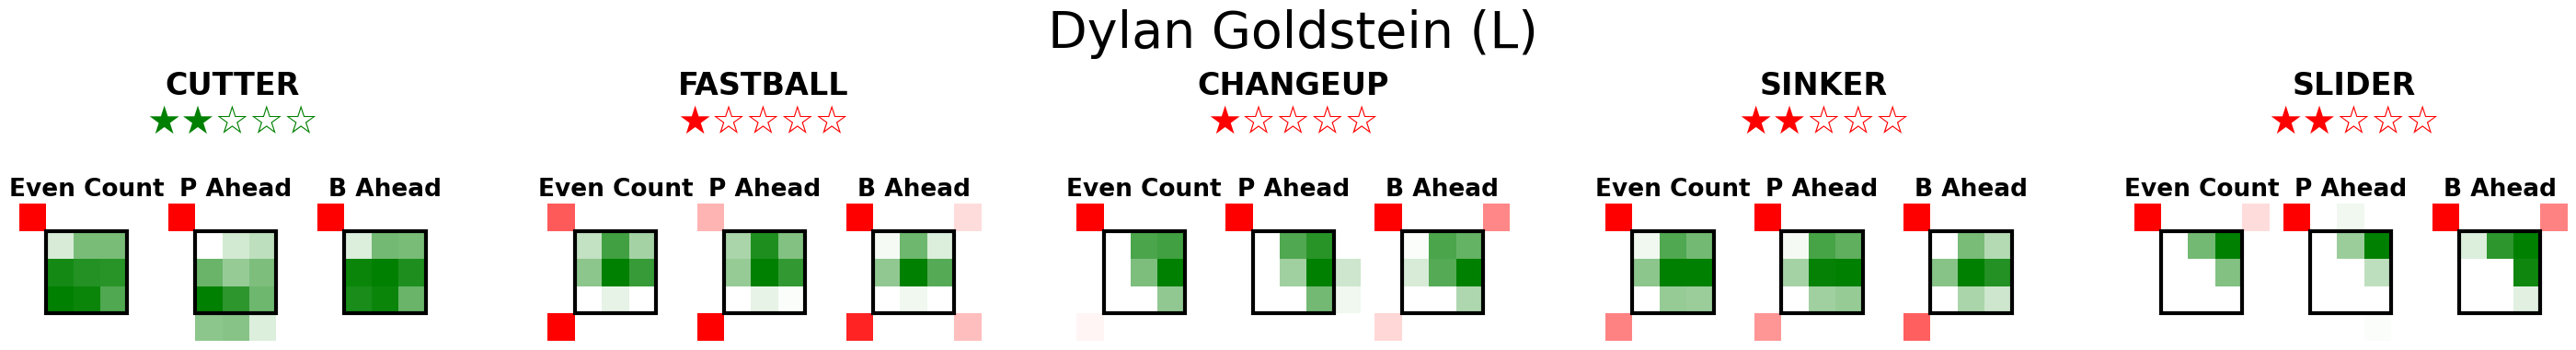

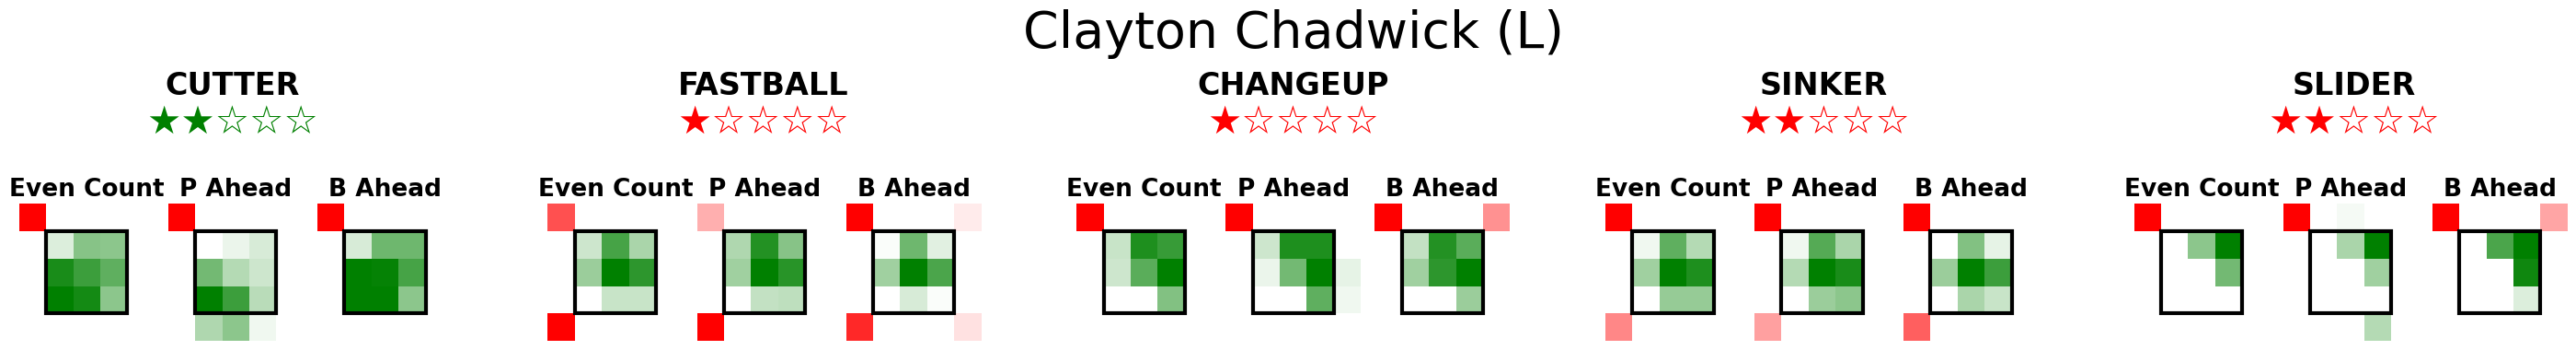

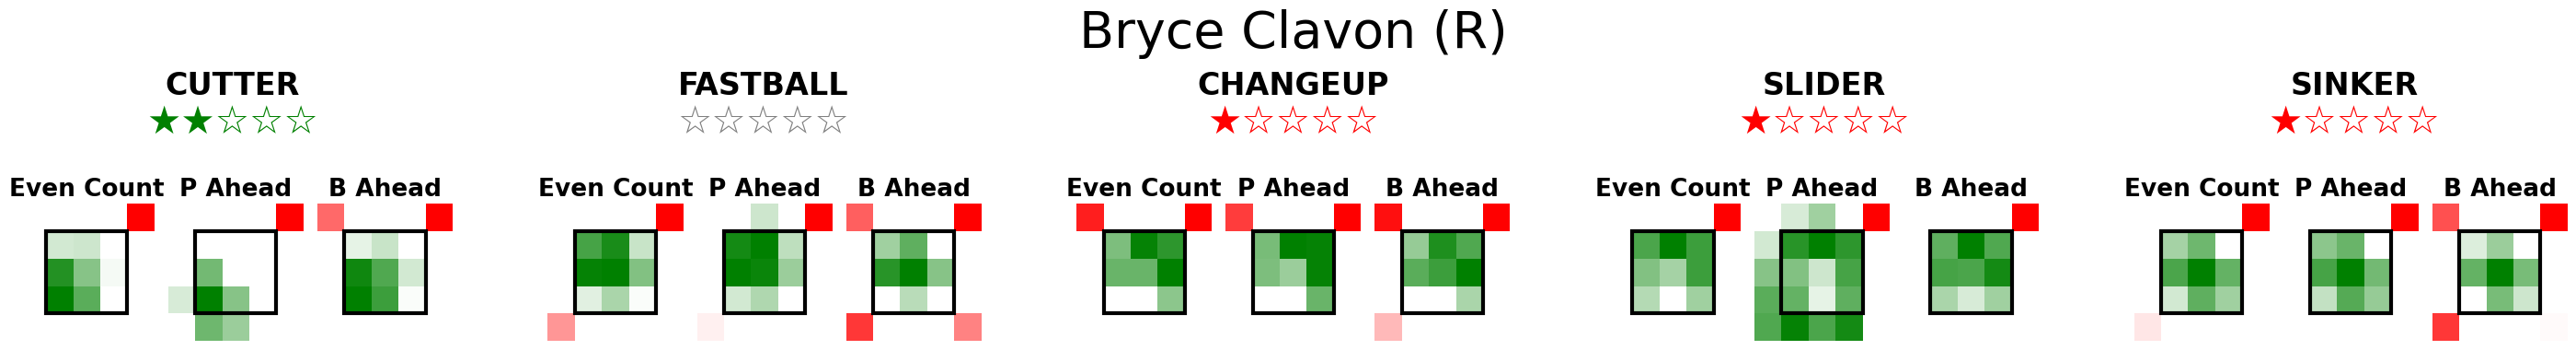

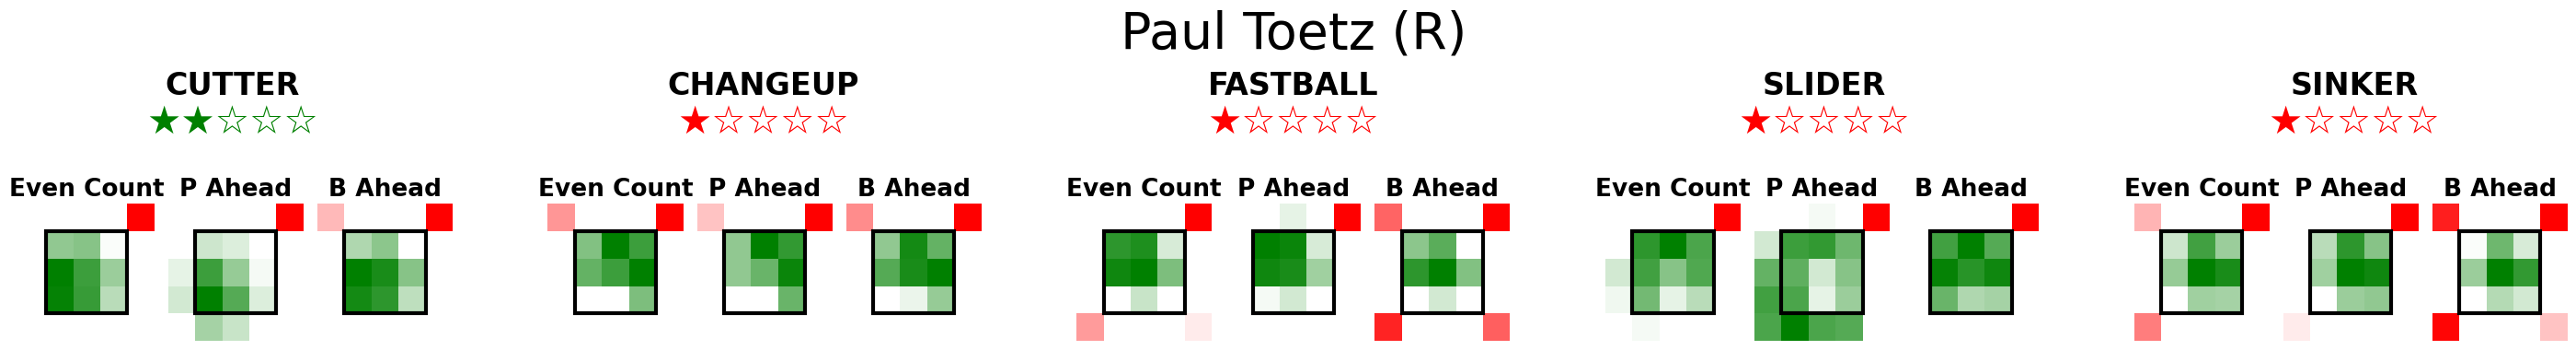

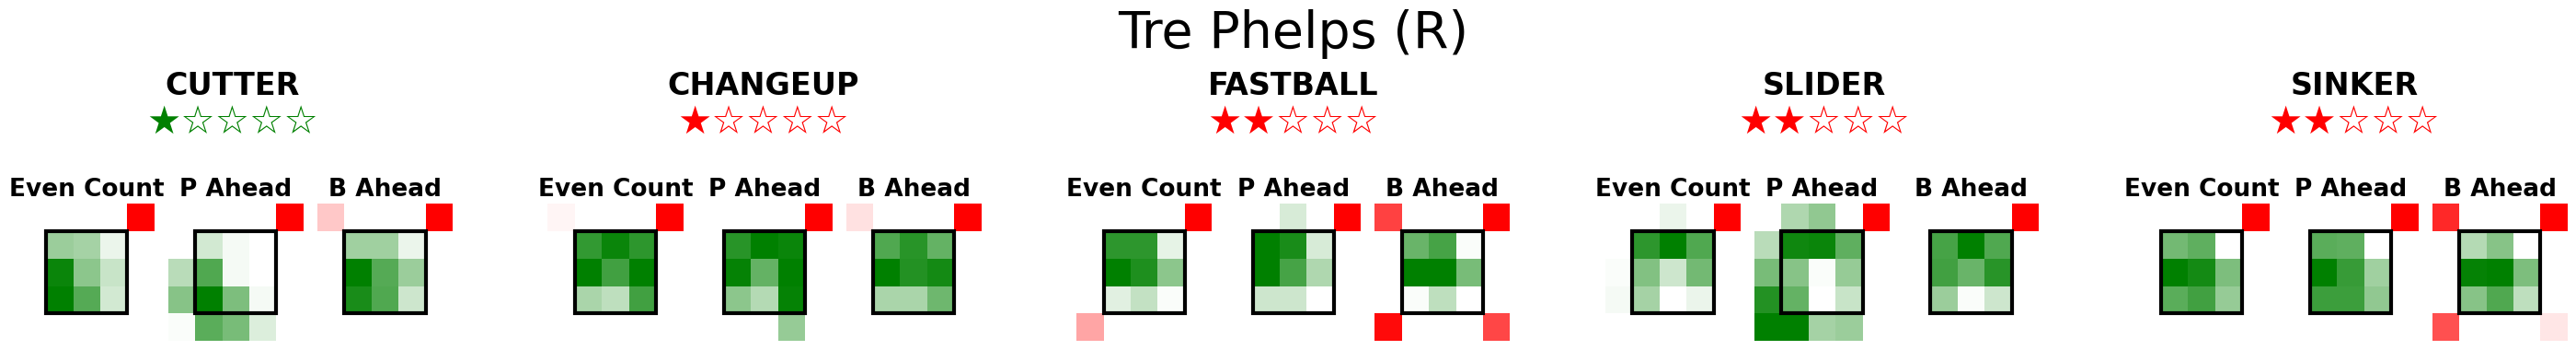

In [9]:
def simulate_synthetic_dataframe(pitches_df, pitcher_id, pitch_type, batter_id):
    synthetic_data = pd.DataFrame(
        list(product(side_buckets, height_buckets, count_values)),
        columns=['PlateLocSideBucket', 'PlateLocHeightBucket', 'CountEncoded']
    )

    synthetic_data['PitchType'] = pitch_type

    pitcher_throws_mode = (
        pitches_df.loc[pitches_df['PitcherId'] == pitcher_id, 'PitcherThrows']
        .mode()
        .iloc[0]
    )

    synthetic_data['PitcherThrows'] = pitcher_throws_mode

    batter_side_mode = (
        pitches_df.loc[(pitches_df['BatterId'] == batter_id) & (pitches_df['PitcherThrows'] == pitcher_throws_mode)]
        .sort_values(by='UTCDateTime', ascending=False)
        .head(100)
        .BatterSide
        .mode().iloc[0]
    )

    platoon_state_encoded = platoon_state_mapping[(pitcher_throws_mode, batter_side_mode)]
    synthetic_data['PlatoonStateEncoded'] = platoon_state_encoded

    synthetic_data['BatterLeagueEncoded'] = (
        pitches_df.loc[pitches_df['BatterId'] == batter_id]
        .sort_values('UTCDateTime', ascending=False)
        .iloc[0]['BatterLeagueEncoded']
    )

    filtered_df = pitches_df.loc[
        (pitches_df['PitcherId'] == pitcher_id) & (pitches_df['PitchType'] == pitch_type)
    ]

    recent_rows = filtered_df.sort_values(by='UTCDateTime', ascending=False).head(100)

    medians = recent_rows[median_features].median().to_dict()

    for feature, median_value in medians.items():
        synthetic_data[feature] = median_value

    pitch_group_mode = pitches_df.loc[
        (pitches_df['PitcherId'] == pitcher_id) & (pitches_df['PitchType'] == pitch_type),
        'PitchGroupEncoded'
    ].mode()[0]
    synthetic_data['PitchGroupEncoded'] = pitch_group_mode

    return synthetic_data


def calculate_batter_metrics(synthetic_df, pitches_df, pitcher_id, batter_id):
    platoon_state_encoded = synthetic_df['PlatoonStateEncoded'].iloc[0]
    pitch_group_encoded = synthetic_df['PitchGroupEncoded'].iloc[0]
    pitcher_throws = synthetic_df['PitcherThrows'].iloc[0]

    batter_id = pitches_df[pitches_df['BatterId'] == batter_id]['BatterId'].mode().iloc[0]

    synthetic_df['PlateLocSide'] = (synthetic_df['PlateLocSideBucket'].astype(float))
    synthetic_df['PlateLocHeight'] = (synthetic_df['PlateLocHeightBucket'].astype(float))

    scaled_columns = [f"{feature}_Scaled" for feature in numerical_features]
    synthetic_df[scaled_columns] = scaler.transform(synthetic_df[numerical_features])

    synthetic_df = hf.add_probabilities(synthetic_df)
    batter_df = hf.add_probabilities(pitches_df[(pitches_df['BatterId'] == batter_id) & (pitches_df['PitcherThrows'] == pitcher_throws)])

    _, pivoted_values = hf.calculate_shrunken_means(
        batter_df, global_means
    )

    synthetic_df['BatterId'] = batter_id
    synthetic_df['Model'] = pitcher_throws
    synthetic_df = hf.compute_batter_stuff_value(synthetic_df, pivoted_values)

    return synthetic_df


def generate_figs(pitches_df, rv_model, pitcher_id, batter_id):
    columns_to_drop = [col for col in pitches_df.columns if col.startswith('DeltaRunValue_') or col.startswith('prob_')]
    pitches_df = pitches_df.drop(columns=columns_to_drop)

    if not pitches_df.index.is_unique:
        pitches_df = pitches_df.reset_index(drop=True)

    pitcher_throws_series = pitches_df.loc[pitches_df['PitcherId'] == pitcher_id, 'PitcherThrows']
    batter_side_series = pitches_df.loc[pitches_df['BatterId'] == batter_id, 'BatterSide']

    if not pitcher_throws_series.empty:
        pitcher_throws_mode = pitcher_throws_series.mode().iloc[0]
    else:
        raise ValueError(f"No matching rows found for pitcher: {pitcher_id}")

    if not batter_side_series.empty:
        batter_side_mode = batter_side_series.mode().iloc[0]
    else:
        raise ValueError(f"No matching rows found for batter: {batter_id}")

    platoon_state_encoded = platoon_state_mapping[(pitcher_throws_mode, batter_side_mode)]

    if not pitches_df.loc[pitches_df['PitcherId'] == pitcher_id]['PlatoonStateEncoded'].isna().all():
        filtered_df = pitches_df[
            (pitches_df['PitcherId'] == pitcher_id) & 
            (pitches_df['TaggedPitchType'] != 'Undefined') & 
            (pitches_df['PlatoonStateEncoded'] == platoon_state_encoded)
        ]
    else:
        filtered_df = pitches_df[
            (pitches_df['PitcherId'] == pitcher_id) & 
            (pitches_df['TaggedPitchType'] != 'Undefined')
        ]

    recent_rows = filtered_df.sort_values(by='UTCDateTime', ascending=False).head(500)

    pitch_type_counts = recent_rows['TaggedPitchType'].value_counts()
    qualifying_pitch_types = pitch_type_counts[pitch_type_counts >= 0.01 * len(recent_rows)].index.tolist()

    pitch_types = (
        filtered_df[filtered_df['TaggedPitchType'].isin(qualifying_pitch_types)]
        .groupby('TaggedPitchType')
        .size()
        .sort_values(ascending=False)
        .index.tolist()
    )

    pitcher_rows = pitches_df[
        (pitches_df['PitcherId'] == pitcher_id) & (pitches_df['TaggedPitchType'] != 'Undefined')
    ].sort_values(by='UTCDateTime', ascending=False).head(1000)

    batter_id = pitches_df[pitches_df['BatterId'] == batter_id]['BatterId'].mode().iloc[0]

    pitch_type_means = []
    pitch_usage = []
    pitch_command = []

    for pitch_type in pitch_types:
        pitch_type_df = (
            pitcher_rows[pitcher_rows['TaggedPitchType'] == pitch_type]
        )

        if pitch_type_df.empty:
            continue
        
        pitch_group_encoded = (
            pitches_df.loc[
                (pitches_df['PitcherId'] == pitcher_id) & 
                (pitches_df['TaggedPitchType'] == pitch_type), 
                'PitchGroupEncoded'
            ].mode()[0]
        )

        pitch_type_df = calculate_batter_metrics(pitch_type_df, pitches_df, pitcher_id, batter_id)

        rel_angles = pitch_type_df[['VertRelAngle', 'HorzRelAngle']].dropna()
        kmeans = KMeans(n_clusters=1, random_state=100)
        kmeans.fit(rel_angles)
        center_vert, center_horz = kmeans.cluster_centers_[0]
        pitch_type_df['DistanceFromCenter'] = np.sqrt(
            (pitch_type_df['VertRelAngle'] - center_vert) ** 2 +
            (pitch_type_df['HorzRelAngle'] - center_horz) ** 2
        )
        command_score = pitch_type_df['DistanceFromCenter'].mean()
        pitch_command.append((pitch_type, command_score))

        if len(pitcher_rows[pitcher_rows['Top/Bottom'] == 'Bottom']) >= 50:
            pitch_usage_value = (
                len(pitch_type_df[pitch_type_df['Top/Bottom'] == 'Bottom']) /
                len(pitcher_rows[pitcher_rows['Top/Bottom'] == 'Bottom'])
            )
        else:
            pitch_usage_value = len(pitch_type_df) / len(pitcher_rows)
        pitch_usage.append((pitch_type, pitch_usage_value))

        expected_features = rv_model.get_booster().feature_names
        rank_df = pitch_type_df[expected_features].copy()
        rank_df['ExpectedRunValue'] = rv_model.predict(rank_df)
        mean_value = rank_df['ExpectedRunValue'].mean()
        if pitch_type in ["Fastball", "Sinker"]:
            mean_value -= 0.01
        pitch_type_means.append((pitch_type, mean_value))
    
    pitch_usage_dict = dict(pitch_usage)

    filtered_pitch_types = [
        (pitch_type, mean_value) for pitch_type, mean_value in pitch_type_means
        if pitch_usage_dict.get(pitch_type, 0) >= 0.01
    ]

    sorted_pitch_types = [pt[0] for pt in sorted(filtered_pitch_types, key=lambda x: x[1])][:5]

    n_pitch_types = len(sorted_pitch_types)
    n_cols = n_pitch_types * 3 + (n_pitch_types - 1)
    width_ratios = [1 if i % 4 != 3 else 0.5 for i in range(n_cols)]

    fig = plt.figure(figsize=(28, 3))
    gs = gridspec.GridSpec(1, n_cols, width_ratios=width_ratios)

    mean = 0.01

    norm = mcolors.Normalize(vmin=mean-0.08, vmax=mean+0.08)
    cmap = mcolors.LinearSegmentedColormap.from_list("green_to_white_to_red", 
                                                    [(0, "green"), (0.2, "white"), (0.8, "white"), (1, "red")], 
                                                    N=256)

    count_values = [0, 1, 2]
    count_translation = {
        0: 'Even Count',
        1: 'P Ahead',
        2: 'B Ahead'
    }

    for col_idx, (pitch_type, count_value) in enumerate(
        [(pt, cv) for pt in sorted_pitch_types for cv in count_values]
    ):
        grid_col_idx = col_idx + (col_idx // 3)
        ax = fig.add_subplot(gs[0, grid_col_idx])

        synthetic_df = simulate_synthetic_dataframe(pitches_df, pitcher_id, pitch_type, batter_id)
        synthetic_df['Year'] = 2024

        synthetic_df = calculate_batter_metrics(synthetic_df, pitches_df, pitcher_id, batter_id)

        expected_features = rv_model.get_booster().feature_names
        model_df = synthetic_df[expected_features]
        model_df['ExpectedRunValue'] = rv_model.predict(model_df)

        count_df = model_df[model_df['CountEncoded'] == count_value]
        heatmap_data = (
            count_df.groupby(['PlateLocHeightBucket', 'PlateLocSideBucket'])['ExpectedRunValue']
            .mean()
            .reset_index()
            .pivot(index="PlateLocHeightBucket", columns="PlateLocSideBucket", values="ExpectedRunValue")
        ).fillna(0)

        command_score = next(score for pt, score in pitch_command if pt == pitch_type)

        sigma = max(0.25, min(command_score, 2)) * 0.5

        smoothed_weighted_data = gaussian_filter(heatmap_data, sigma=sigma)
        smoothed_weighted_data = smoothed_weighted_data[1:-1, 1:-1]

        sns.heatmap(
            smoothed_weighted_data,
            cmap=cmap,
            xticklabels=False,
            yticklabels=False,
            cbar=False,
            ax=ax
        )

        ax.add_patch(
            patches.Rectangle(
                (1, 1),  
                3,  
                3,     
                edgecolor='black', facecolor='none', linewidth=3
            )
        )

        title_fontsize = 24 - len(sorted_pitch_types)

        ax.set_title(
            f"{count_translation.get(count_value, 'Unknown Count')}",
            fontsize=title_fontsize,
            fontweight='bold'
        )
        ax.invert_yaxis()

    for idx, pitch_type in enumerate(sorted_pitch_types):
        pitch_type_mean_value = next(mean for pitch, mean in pitch_type_means if pitch == pitch_type)
        second_plot_idx = idx * 4 + 1
        start_x = sum(width_ratios[:second_plot_idx])
        plot_width = width_ratios[second_plot_idx]
        label_x = (start_x + plot_width / 2) / sum(width_ratios)

        fig.text(
            label_x,
            0.94,
            pitch_type.upper(),
            ha="center",
            fontsize=24,
            fontweight="bold"
        )

        if pitch_type_mean_value <= -0.045:
            stars = "★★★★★"
            star_color = "green"
        elif -0.045 < pitch_type_mean_value <= -0.035:
            stars = "★★★★☆"
            star_color = "green"
        elif -0.035 < pitch_type_mean_value <= -0.025:
            stars = "★★★☆☆"
            star_color = "green"
        elif -0.025 < pitch_type_mean_value <= -0.015:
            stars = "★★☆☆☆"
            star_color = "green"
        elif -0.015 < pitch_type_mean_value <= -0.005:
            stars = "★☆☆☆☆"
            star_color = "green"
        elif -0.005 < pitch_type_mean_value <= 0.005:
            stars = "☆☆☆☆☆"
            star_color = "gray"
        elif 0.005 < pitch_type_mean_value <= 0.015:
            stars = "★☆☆☆☆"
            star_color = "red"
        elif 0.015 < pitch_type_mean_value <= 0.025:
            stars = "★★☆☆☆"
            star_color = "red"
        elif 0.025 < pitch_type_mean_value <= 0.035:
            stars = "★★★☆☆"
            star_color = "red"
        elif 0.035 < pitch_type_mean_value <= 0.045:
            stars = "★★★★☆"
            star_color = "red"
        else:
            stars = "★★★★★"
            star_color = "red"

        y_offset = 0.8

        fig.text(
            label_x,
            y_offset,
            stars,
            ha="center",
            fontsize=30,
            fontweight="bold",
            color=star_color
        )

    batter = pitches_df.loc[pitches_df['BatterId'] == batter_id, 'Batter'].mode()

    if not batter.empty:
        batter_name = " ".join(reversed(batter.iloc[0].split(", ")))
        handedness = "(L)" if platoon_state_encoded in [0, 2] else "(R)"
        batter_display_name = f"{batter_name} {handedness}"
    else:
        batter_display_name = "Unknown Batter"

    fig.suptitle(f'{batter_display_name}', fontsize=40, y=1.25)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    return fig, handedness


def generate_fig_dict(pitches_df, final_model, pitcher_id, batters):
    if pitches_df['BatterId'].dtype != 'float64':
        pitches_df['BatterId'] = pitches_df['BatterId'].astype(float)

    fig_dict = {}

    primary_pitcher_id = float(pitcher_id[0])
    for p_id in pitcher_id[1:]:
        pitches_df.loc[pitches_df['PitcherId'] == float(p_id), 'PitcherId'] = primary_pitcher_id

    for batter_group in batters:
        primary_batter_id = float(batter_group[0])

        for batter_id in batter_group[1:]:
            pitches_df.loc[pitches_df['BatterId'] == float(batter_id), 'BatterId'] = primary_batter_id

        fig, handedness = generate_figs(pitches_df, final_model, primary_pitcher_id, primary_batter_id)
        key = f"{int(primary_batter_id)}_{handedness}"
        fig_dict[key] = fig

    return fig_dict


def generate_pdf(pitcher_id, batters, opponent, date):
    figures = generate_fig_dict(pitches_df, rv_model, pitcher_id, batters)
    
    pdf = FPDF(format='letter')
    pdf.add_page()

    pdf.image("georgia_logo.png", x=170, y=5, w=30)

    pitcher = pitches_df.loc[pitches_df['PitcherId'] == pitcher_id[0], 'Pitcher'].mode()

    if not pitcher.empty:
        pitcher_name = pitcher.iloc[0]
    else:
        pitcher_name = None

    pitcher_name = " ".join(reversed(pitcher_name.split(", ")))
    pdf.set_font("Arial", size=16, style='B')
    pdf.cell(190, 10, txt=f"{pitcher_name} vs. {opponent}", ln=True, align="C")

    pdf.set_font("Arial", size=10)
    y_offset = pdf.get_y()
    pdf.set_xy(10, y_offset - 2.5)
    pdf.cell(190, 10, txt=f"{date}", ln=True, align="C")

    y_offset = 15
    max_width = 160
    lhh_width = 12.5
    rhh_width = 12

    page_width = 210
    total_width = max_width + rhh_width
    total_left_shift = max_width + lhh_width

    center_x_for_player = (page_width - max_width) / 2
    center_x_for_rhh = center_x_for_player + max_width
    center_x_for_lhh = center_x_for_player - lhh_width

    for name, fig in figures.items():
        fig.savefig(f"{name}.png", format='png', bbox_inches='tight', pad_inches=0.1)

        line_start = 10
        line_end = 200
        pdf.set_draw_color(0, 0, 0)
        pdf.line(line_start, y_offset + 12, line_end, y_offset + 12)

        if '(R)' in name:
            img_path = f'{name}.png'
            pdf.image(img_path, x=center_x_for_player, y=y_offset + 15, w=max_width)

            rhh_img_path = "rhh.png"
            pdf.image(rhh_img_path, x=center_x_for_rhh, y=y_offset + 17, w=rhh_width)
        
        else:
            img_path = f'{name}.png'
            pdf.image(img_path, x=center_x_for_player, y=y_offset + 15, w=max_width)

            lhh_img_path = "lhh.png"
            pdf.image(lhh_img_path, x=center_x_for_lhh, y=y_offset + 15, w=lhh_width)
        
        y_offset += 27.5

        if y_offset > 300:
            pdf.add_page()
            y_offset = 10

        os.remove(f"{name}.png")

    pitcher_last_name = pitcher_name.split(" ")[1].lower()
    opponent_name = opponent.replace(" ", "").lower()
    date_formatted = datetime.strptime(date, "%B %d, %Y").strftime("%Y%m%d")

    os.makedirs('pdfs', exist_ok=True)
    file_path = f"pdfs/{pitcher_last_name}_{opponent_name}_{date_formatted}.pdf"
    pdf.output(file_path)
    print(f"PDF saved as {file_path}")

### DO NOT TOUCH THE CODE ABOVE

### PUT PITCHER ID HERE
pitcher_id = [1000269766, 10086131]

### PUT BATTER IDS HERE
batters = [
            [695477, 1000052101], ### BATTER 1
            [809707, 1000133690], ### BATTER 2
            [702705, 1000107443], ### BATTER 3
            [692232, 1000064202], ### BATTER 4
            [687408, 1000013128], ### BATTER 5
            [699821, 1000079889], ### BATTER 6
            [1000255777], ### BATTER 7
            [802119, 1000073064], ### BATTER 8
            [804569, 1000133791] ### BATTER 9
]

### PUT THE OPPONENT HERE
opponent = "Georgia"

### PUT THE DATE HERE
date = "January 29, 2025"

## LEAVE THIS CODE AS IS
generate_pdf(pitcher_id=pitcher_id, 
            batters=batters,
            opponent=opponent,
            date=date)